### Object Queries

This Notebook shows examples of querying for an object in a memory. There are three main cases:
1. Querying an object that exists
2. Querying an object that does not exist
3. Querying an object that exists at more than one location

In [1]:
%matplotlib inline
import nengo.spa as spa
import numpy as np
import matplotlib.pyplot as plt
import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import encode_point, make_good_unitary, get_heatmap_vectors

Set up the dimensionality, axis vectors, and area of interest

In [2]:
seed = 13
np.random.seed(seed)
dim = 512
res = 128
limit = 5
xs = np.linspace(-limit, limit, res)
ys = np.linspace(-limit, limit, res)

rng = np.random.RandomState(seed=seed)
x_axis_sp = make_good_unitary(dim, rng=rng)
y_axis_sp = make_good_unitary(dim, rng=rng)

# precompute the vectors required for plotting to speed things up later
heatmap_vectors = get_heatmap_vectors(xs, ys, x_axis_sp, y_axis_sp)

In [3]:
def plot_heatmap(sp, name='', vmin=-1, vmax=1, cmap='plasma', invert=False):
    # sp has shape (dim,) and heatmap_vectors have shape (xs, ys, dim) so the result will be (xs, ys)
    if sp.__class__.__name__ == 'SemanticPointer':
        vs = np.tensordot(sp.v, heatmap_vectors, axes=([0], [2]))
    else:
        vs = np.tensordot(sp, heatmap_vectors, axes=([0], [2]))

    if cmap == 'diverging':
        cmap = sns.diverging_palette(150, 275, s=80, l=55, as_cmap=True)

    plt.imshow(vs, origin='lower', interpolation='none', extent=(xs[0], xs[-1], ys[0], ys[-1]), vmin=vmin, vmax=vmax, cmap=cmap)

    plt.title(name)
    plt.show()

Create some semantic items to use

In [4]:
n_items = 10
items = []
for i in range(n_items):
    items.append(spa.SemanticPointer(dim))

Small example of encoding items in memory

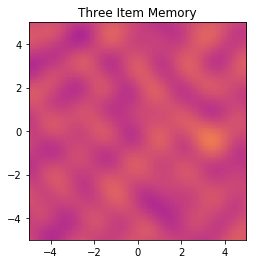

In [5]:
pos1 = encode_point(2, 2, x_axis_sp=x_axis_sp, y_axis_sp=y_axis_sp)
pos2 = encode_point(-1, 3, x_axis_sp=x_axis_sp, y_axis_sp=y_axis_sp)
pos3 = encode_point(2.5, -1, x_axis_sp=x_axis_sp, y_axis_sp=y_axis_sp)
mem = pos1*items[0] + pos2*items[1] + pos3*items[2]
fig = plot_heatmap(
    mem,
    name='Three Item Memory'
)

Looking at the similarity plot of the memory itself, there should be no locations jumping out. Ideally it should just be noise. This is because the locations have all been bound with item vectors and therefore should be dissimilar to their original location as well as other locations.

Now let's try decoding the locations of some items.

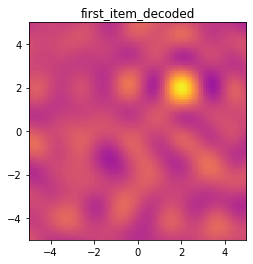

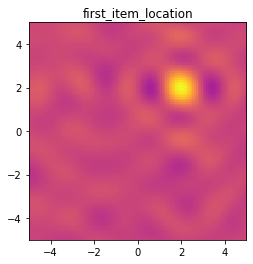

In [6]:
first_item_decoded = mem *~ items[0]
plot_heatmap(
    first_item_decoded,
    name='first_item_decoded'
)
plot_heatmap(
    pos1,
    name='first_item_location'
)

The output from retrieving the location of the first item is very similar to the true location of that item. Most importantly, the maximum location on the heatmap is the same.

Looking at the output if the item did not exist in the memory

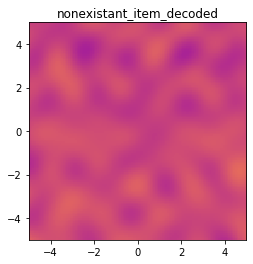

In [7]:
nonexistant_item_decoded = mem *~ items[3]
fig = plot_heatmap(
    nonexistant_item_decoded,
    name='nonexistant_item_decoded'
)

No location as strong, but there still is clearly a maximum. Need some thresholding to determine if a match is found vs. nothing found

Now let's look at what happens if the same item exists at multiple locations

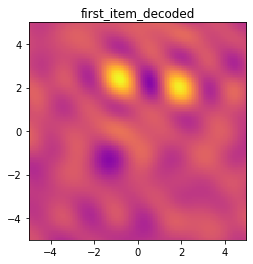

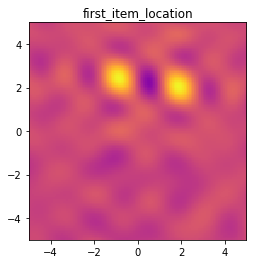

In [8]:
mem2 = pos1*items[0] + pos2*items[1] + pos3*items[0]
first_item_decoded = mem2 *~ items[0]
fig = plot_heatmap(
    first_item_decoded,
    name='first_item_decoded'
)
fig = plot_heatmap(
    pos1+pos3,
    name='first_item_location'
)

both locations are highly similar